# Proyecto 4: Faces in The Wild

**Integrantes**:
- Lucas Carranza
- David Herencia
- Kalos Lazo
- Lenin Chavez

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

import torchvision
from torchvision import transforms, datasets

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda:0


## Exploración del Dataset

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Split the 'image1_image2' column into two columns
train_df[['image1', 'image2']] = train_df['image1_image2'].str.split('_', expand=True)
test_df[['image1', 'image2']] = test_df['image1_image2'].str.split('_', expand=True)

# Drop the original 'image1_image2' column
train_df.drop(columns=['image1_image2'], inplace=True)
test_df.drop(columns=['image1_image2'], inplace=True)

# Reorder cols
train_df = train_df[['image1', 'image2', 'label']]

# Convert label image to number
# diff = 0
# same = 1
train_df['label'] = pd.factorize(train_df['label'])[0]

train_df.head()

,image1,image2,label
0,1485,4047,0
1,5335,6055,1
2,10796,3696,1
3,11991,6672,1
4,7003,2539,1


In [4]:
# Helper functions to load images from dataset and plot them
def load_img(img_id):
    path = f"images/{img_id}.png"
    return Image.open(path)

def plot_imgs(imgs, size=3):
    img_number = imgs.shape[0]
    rows = cols = math.ceil(np.sqrt(img_number))
    fig = plt.figure(figsize=(rows*size, cols*size))
    for i in range(img_number):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

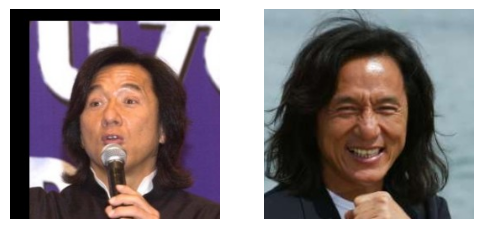

(250, 250, 3)

In [5]:
# Example on how to load and plot images
im1 = load_img(train_df['image1'][1347])
im2 = load_img(train_df['image2'][1347])
plot_imgs(np.array([im1, im2]))

np.array(im1).shape # Imagenes de 250x250 en formato RGB

## Modelo 1: Siamese CNN

### Data Loader for Siamese CNN

Debido a que la Red Neuronal Convolucional requiere de 2 entradas de imagenes para validar si corresponden a la misma persona o no, requerimos de un Dataset personalizado, donde la entrada consista en 2 imagenes y un label. Es por esto que creamos la clase `TwoImageDataset` a partir de la clase `Dataset` de pytorch, la cual puede obtener todos los pares de imágenes y cargarlos de dos en dos junto con el label que nos indican si son la misma persona o no.

In [6]:
class TwoImageDataset(Dataset):
    def __init__(self, df, transform=None, is_test=False):
        self.df = df
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img1_id = self.df.iloc[idx, 0]
        img2_id = self.df.iloc[idx, 1]

        img1 = load_img(img1_id).convert('RGB')
        img2 = load_img(img2_id).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        if self.is_test:
            return img1, img2
            
        label = self.df.iloc[idx, 2]
        return img1, img2, torch.tensor(label, dtype=torch.float32)

In [7]:
batch_size = 8
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with Image stats
])

# Train-Test split
from sklearn.model_selection import train_test_split
train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Initializing custom datasets
train_dataset = TwoImageDataset(train_subset_df, transform=transform)
val_dataset = TwoImageDataset(val_subset_df, transform=transform)
test_dataset = TwoImageDataset(test_df, transform=transform, is_test=True)

# Initialize the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Example to check the dataloader
for img1, img2, label in train_dataloader:
    print(img1.shape, img2.shape, label.shape)
    print(label)
    break

torch.Size([8, 3, 250, 250]) torch.Size([8, 3, 250, 250]) torch.Size([8])
tensor([1., 1., 1., 1., 1., 1., 0., 1.])


In [18]:
class SiameseCNN(nn.Module):
    def __init__(self):
        super(SiameseCNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), #250
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), #250
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #125
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1), #125
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), #125
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #62

            nn.Conv2d(128, 256, kernel_size=3, padding=1), #62
            # nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #31
            
            nn.Dropout(0.15)
        )

        self.fc = nn.Sequential(
            nn.Linear(256*31*31 * 2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.15),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        return x

    def forward(self, img1, img2):
        out1 = self.forward_once(img1)
        out2 = self.forward_once(img2)
        # print(out1.shape)
        
        concat = torch.cat((out1, out2), 1)
        # print(concat.shape)
        
        output = self.fc(concat)
        output = torch.flatten(output)
        # print(output.shape)
        return output

    def train_cnn(self, train_loader, loss_fn, optimizer, scheduler=None, num_epochs=5):
        total_step = len(train_loader)
        list_loss = []
        for epoch in range(num_epochs):
            model.train()
            for i, (images1, images2, labels) in enumerate(train_loader):
                images1 = images1.to(device)
                images2 = images2.to(device)
                labels = labels.to(device)
    
                output = self(images1, images2)
                loss = loss_fn(output, labels)
    
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
                list_loss.append(loss.item())
                i += 1
    
                if (i + 1) % 5 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {}'
                          .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

            if scheduler:
                scheduler.step()
    
        print('Finished Training Trainset')
        return list_loss
    
    def predict(self, dataloader, with_labels=False):
        y_pred = []
        model.eval()
        with torch.no_grad():
            if not with_labels:
                for image1, image2 in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    probs = torch.sigmoid(output)
                    pred = torch.round(probs)
                    y_pred.append(int(pred.item()))
            else:
                for image1, image2, _ in dataloader:
                    image1, image2 = image1.to(device), image2.to(device)
                    output = self(image1, image2)
                    output = output.cpu()
                    pred = torch.round(output)
                    y_pred.append(int(pred.item()))
            return y_pred

In [19]:
learning_rate = 0.001
model = SiameseCNN().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = StepLR(optimizer=optimizer, step_size=1, gamma=0.1)

In [20]:
torch.cuda.empty_cache()
epochs = 10
list_loss = model.train_cnn(train_dataloader, loss_fn, optimizer, scheduler=scheduler, num_epochs=epochs)

Epoch [1/10], Step [5/220], Loss: 1.217708706855774
Epoch [1/10], Step [10/220], Loss: 0.8444516062736511
Epoch [1/10], Step [15/220], Loss: 0.9614845514297485
Epoch [1/10], Step [20/220], Loss: 0.9283863306045532
Epoch [1/10], Step [25/220], Loss: 0.8216087818145752
Epoch [1/10], Step [30/220], Loss: 0.7761063575744629
Epoch [1/10], Step [35/220], Loss: 0.609696626663208
Epoch [1/10], Step [40/220], Loss: 0.7529503107070923
Epoch [1/10], Step [45/220], Loss: 0.6774989366531372
Epoch [1/10], Step [50/220], Loss: 0.9392931461334229
Epoch [1/10], Step [55/220], Loss: 0.7398350238800049
Epoch [1/10], Step [60/220], Loss: 0.7930306196212769
Epoch [1/10], Step [65/220], Loss: 0.7683942317962646
Epoch [1/10], Step [70/220], Loss: 0.603763222694397
Epoch [1/10], Step [75/220], Loss: 0.823512613773346
Epoch [1/10], Step [80/220], Loss: 0.8045680522918701
Epoch [1/10], Step [85/220], Loss: 0.5670093297958374
Epoch [1/10], Step [90/220], Loss: 0.6759359836578369
Epoch [1/10], Step [95/220], Loss

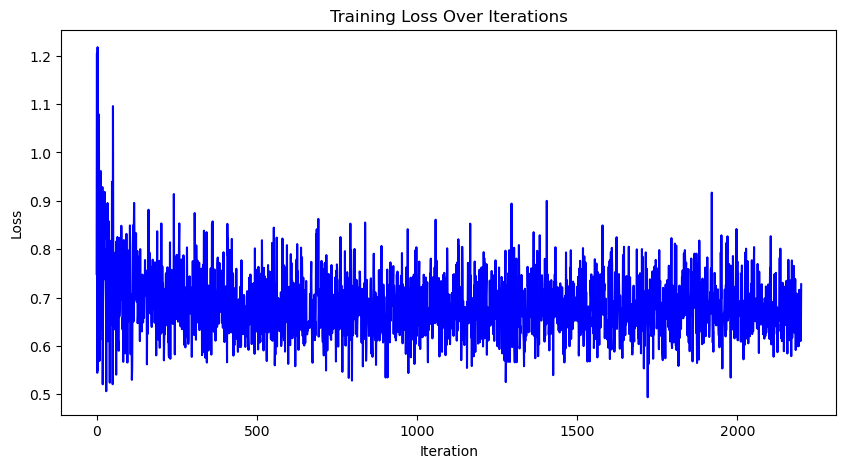

In [21]:
# Plot the loss function
plt.figure(figsize=(10, 5))
plt.plot(list_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       220
           1       0.52      0.52      0.52       220

    accuracy                           0.52       440
   macro avg       0.52      0.52      0.52       440
weighted avg       0.52      0.52      0.52       440



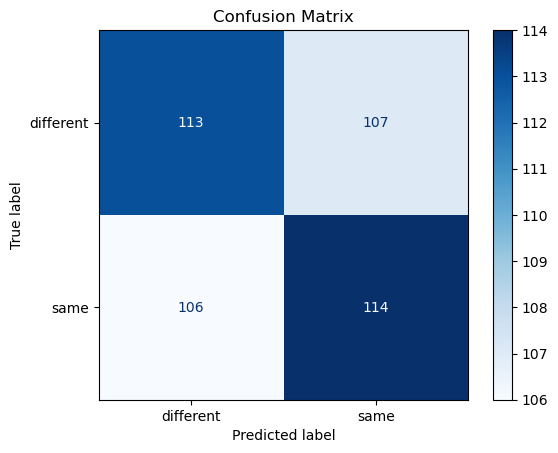

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

val_pred = model.predict(val_dataloader, with_labels=True)
cm = confusion_matrix(val_subset_df['label'], val_pred)

# Generate the classification report
report = classification_report(val_subset_df['label'], val_pred)
print("Classification Report:")
print(report)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['different', 'same'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [13]:
test_values = model.predict(test_dataloader)

## Modelo 2: ??

## Experimentación

## Testing